Epoch 1/20
196/196 [==============================] - 3s 8ms/step - loss: 0.0228
Epoch 2/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0182
Epoch 4/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0182
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0182
Epoch 6/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0185
Epoch 7/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 8/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0180
Epoch 9/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0182
Epoch 10/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 11/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 12/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 13/20
196/196 [====

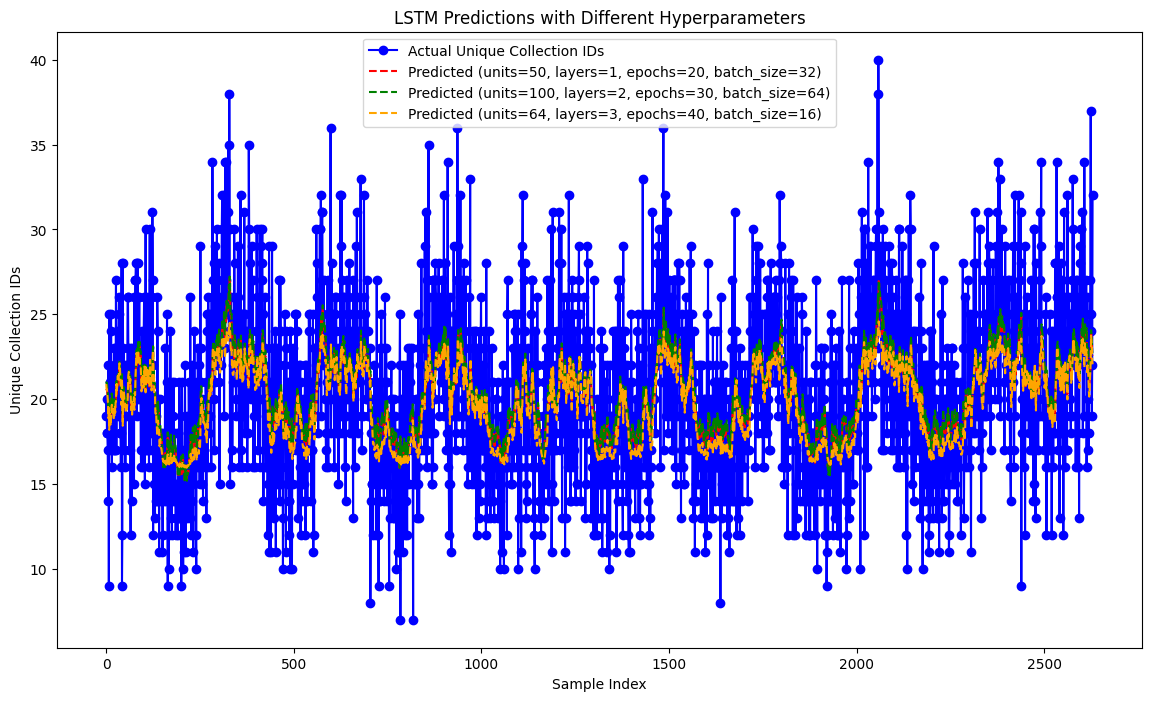

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the CSV file
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    return {'unique_collection_ids': unique_collection_ids_count}

def create_interval_features(df):
    start_time = df['start_time'].min()
    end_time = df['start_time'].max()
    current_start = start_time
    results = []
    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = df[(df['start_time'] >= current_start) & (df['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start
            interval_result['interval_end'] = current_end
            results.append(interval_result)
        current_start = current_end
    return pd.DataFrame(results)

# Prepare features for training and testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)
train_intervals_df = create_interval_features(train_data)
test_intervals_df = create_interval_features(test_data)

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the unique_collection_ids
train_scaled = scaler.fit_transform(train_intervals_df['unique_collection_ids'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_intervals_df['unique_collection_ids'].values.reshape(-1, 1))

# Sequence length
sequence_length = 20  # Increased from 10 to capture more temporal context

# Convert data into sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

X_train = create_sequences(train_scaled, sequence_length)
y_train = train_scaled[sequence_length:]
X_test = create_sequences(test_scaled, sequence_length)
y_test = test_scaled[sequence_length:]

# Define hyperparameter sets
hyperparams = [
    {'units': 50, 'layers': 1, 'epochs': 20, 'batch_size': 32},
    {'units': 100, 'layers': 2, 'epochs': 30, 'batch_size': 64},
    {'units': 64, 'layers': 3, 'epochs': 40, 'batch_size': 16}
]

# Train and predict using different LSTM models
results = []
for params in hyperparams:
    model = Sequential()
    for i in range(params['layers']):
        if i == 0:
            model.add(LSTM(params['units'], return_sequences=(params['layers'] > 1), input_shape=(sequence_length, 1)))
        else:
            model.add(LSTM(params['units'], return_sequences=(i < params['layers'] - 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)
    
    predictions = model.predict(X_test)
    
    # Inverse transform the predictions 
    predictions_inverted = scaler.inverse_transform(predictions)
    y_test_inverted = scaler.inverse_transform(y_test)
    
    results.append({
        'params': params,
        'predictions': predictions_inverted.flatten(),
        'y_test': y_test_inverted.flatten()
    })


def plot_lstm_results(results):
    plt.figure(figsize=(14, 8))
    
    # Define a color palette
    colors = ['red', 'green', 'orange']
    

    plt.plot(range(len(results[0]['y_test'])), results[0]['y_test'], marker='o', color='blue', label='Actual Unique Collection IDs')
    
  
    for i, result in enumerate(results):
        plt.plot(range(len(result['predictions'])), result['predictions'], linestyle='--', 
                 color=colors[i], 
                 label=f"Predicted (units={result['params']['units']}, layers={result['params']['layers']}, epochs={result['params']['epochs']}, batch_size={result['params']['batch_size']})")
    
    plt.xlabel('Sample Index')
    plt.ylabel('Unique Collection IDs')
    plt.title('LSTM Predictions with Different Hyperparameters')
    plt.legend()
    plt.show()

# Plot the comparison
plot_lstm_results(results)


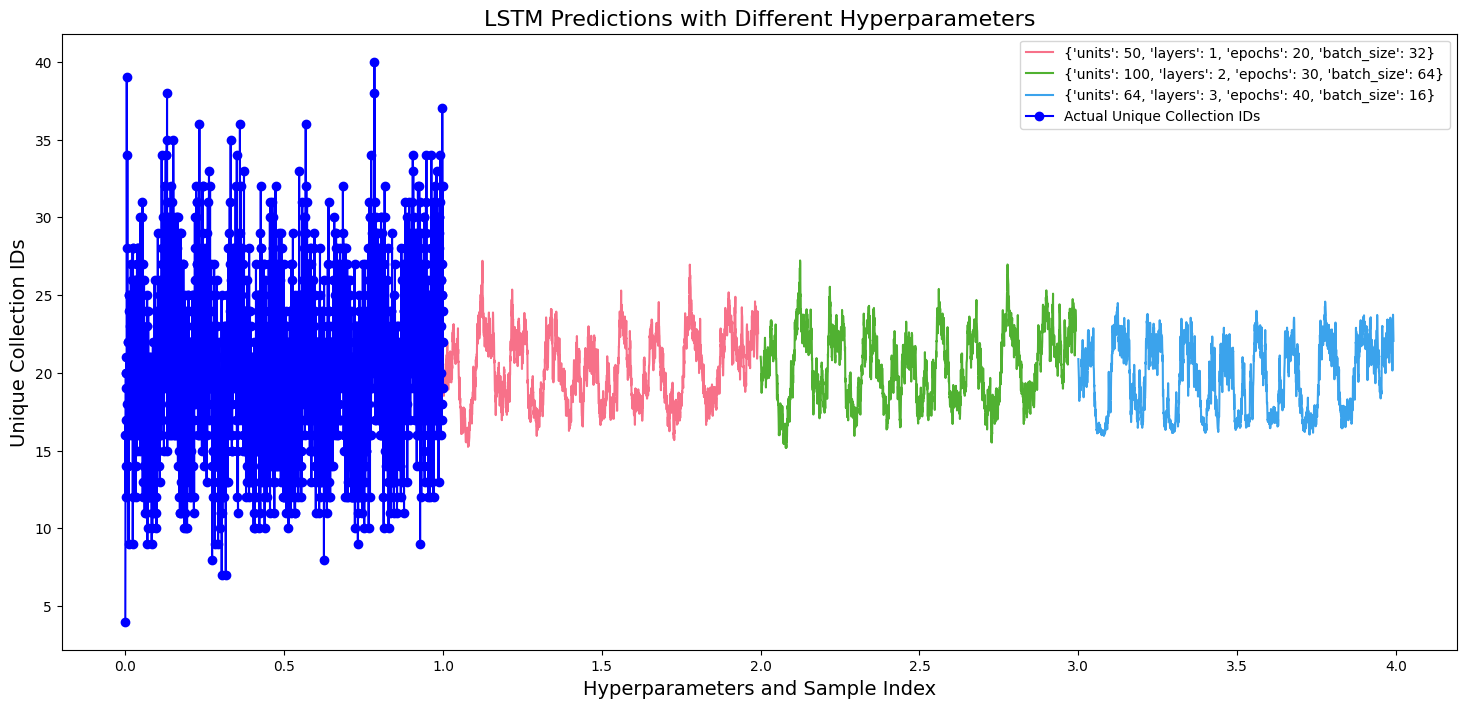

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plot_data = pd.DataFrame({
    'Parameter': np.concatenate([[str(result['params'])] * len(result['predictions']) for result in results]),
    'Predicted Unique Collection IDs': np.concatenate([result['predictions'] for result in results]),
    'Sample Index': np.concatenate([np.arange(len(result['predictions'])) for result in results])
})


plot_data['X'] = plot_data['Parameter'].map({str(hyperparams[i]): i + 1 for i in range(len(hyperparams))}) + plot_data['Sample Index'] / len(test_intervals_df)


plt.figure(figsize=(18, 8))
sns.lineplot(data=plot_data, x='X', y='Predicted Unique Collection IDs', hue='Parameter', palette='husl')


plt.plot(test_intervals_df.index / len(test_intervals_df), test_intervals_df['unique_collection_ids'], marker='o', color='blue', label='Actual Unique Collection IDs')


plt.title('LSTM Predictions with Different Hyperparameters', fontsize=16)
plt.xlabel('Hyperparameters and Sample Index', fontsize=14)
plt.ylabel('Unique Collection IDs', fontsize=14)
plt.legend()
plt.show()

Epoch 1/20
196/196 [==============================] - 3s 8ms/step - loss: 0.0063
Epoch 2/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 4/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 6/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 7/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 8/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0058
Epoch 9/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0057
Epoch 10/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0057
Epoch 11/20
196/196 [==============================] - 2s 9ms/step - loss: 0.0057
Epoch 12/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0057
Epoch 13/20
196/196 [====

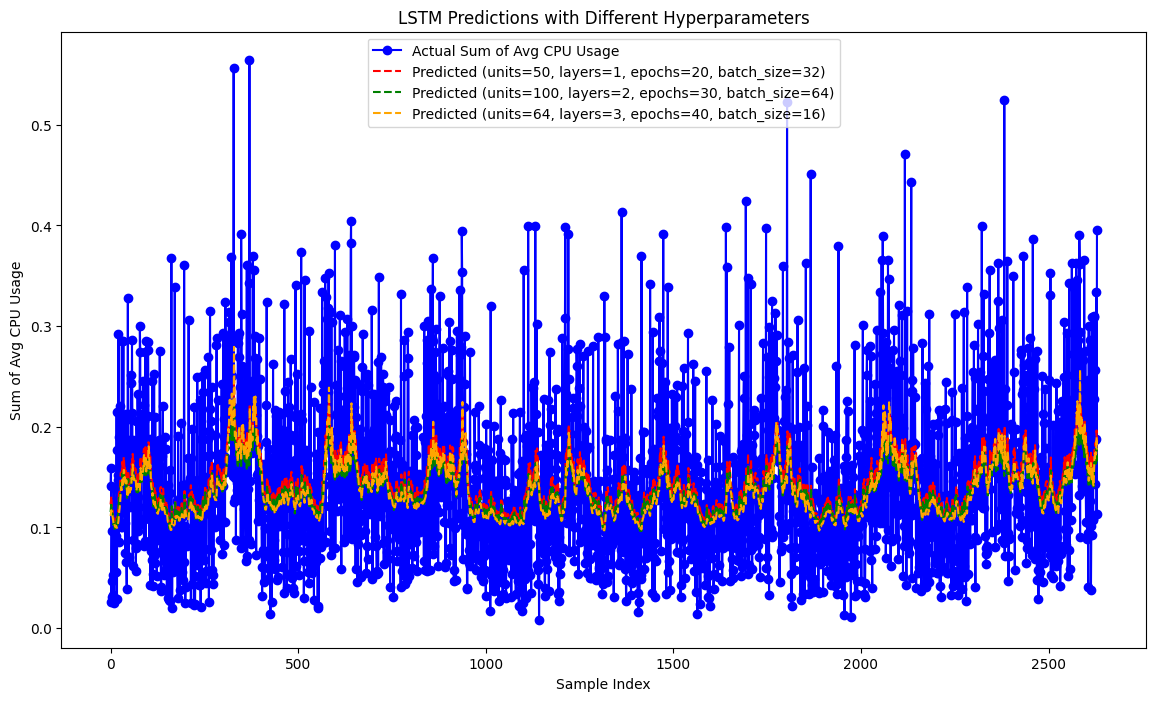

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    return {'sum_avg_cpu': sum_avg_cpu}

def create_interval_features(df):
    start_time = df['start_time'].min()
    end_time = df['start_time'].max()
    current_start = start_time
    results = []
    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = df[(df['start_time'] >= current_start) & (df['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start
            interval_result['interval_end'] = current_end
            results.append(interval_result)
        current_start = current_end
    return pd.DataFrame(results)

# Prepare features for training and testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)
train_intervals_df = create_interval_features(train_data)
test_intervals_df = create_interval_features(test_data)

# Sequence length
sequence_length = 20  

# Convert data into sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

X_train = create_sequences(train_intervals_df['sum_avg_cpu'].values, sequence_length)
y_train = train_intervals_df['sum_avg_cpu'].values[sequence_length:]
X_test = create_sequences(test_intervals_df['sum_avg_cpu'].values, sequence_length)
y_test = test_intervals_df['sum_avg_cpu'].values[sequence_length:]

# Define hyperparameter sets
hyperparams = [
    {'units': 50, 'layers': 1, 'epochs': 20, 'batch_size': 32},
    {'units': 100, 'layers': 2, 'epochs': 30, 'batch_size': 64},
    {'units': 64, 'layers': 3, 'epochs': 40, 'batch_size': 16}
]

# Train and predict using different LSTM models
results = []
for params in hyperparams:
    model = Sequential()
    for i in range(params['layers']):
        if i == 0:
            model.add(LSTM(params['units'], return_sequences=(params['layers'] > 1), input_shape=(sequence_length, 1)))
        else:
            model.add(LSTM(params['units'], return_sequences=(i < params['layers'] - 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)
    
    predictions = model.predict(X_test)
    
    results.append({
        'params': params,
        'predictions': predictions.flatten(),
        'y_test': y_test.flatten()
    })


def plot_lstm_results(results):
    plt.figure(figsize=(14, 8))
    
 
    colors = ['red', 'green', 'orange']
    
  
    plt.plot(range(len(results[0]['y_test'])), results[0]['y_test'], marker='o', color='blue', label='Actual Sum of Avg CPU Usage')
    

    for i, result in enumerate(results):
        plt.plot(range(len(result['predictions'])), result['predictions'], linestyle='--', 
                 color=colors[i], 
                 label=f"Predicted (units={result['params']['units']}, layers={result['params']['layers']}, epochs={result['params']['epochs']}, batch_size={result['params']['batch_size']})")
    
    plt.xlabel('Sample Index')
    plt.ylabel('Sum of Avg CPU Usage')
    plt.title('LSTM Predictions with Different Hyperparameters')
    plt.legend()
    plt.show()


plot_lstm_results(results)


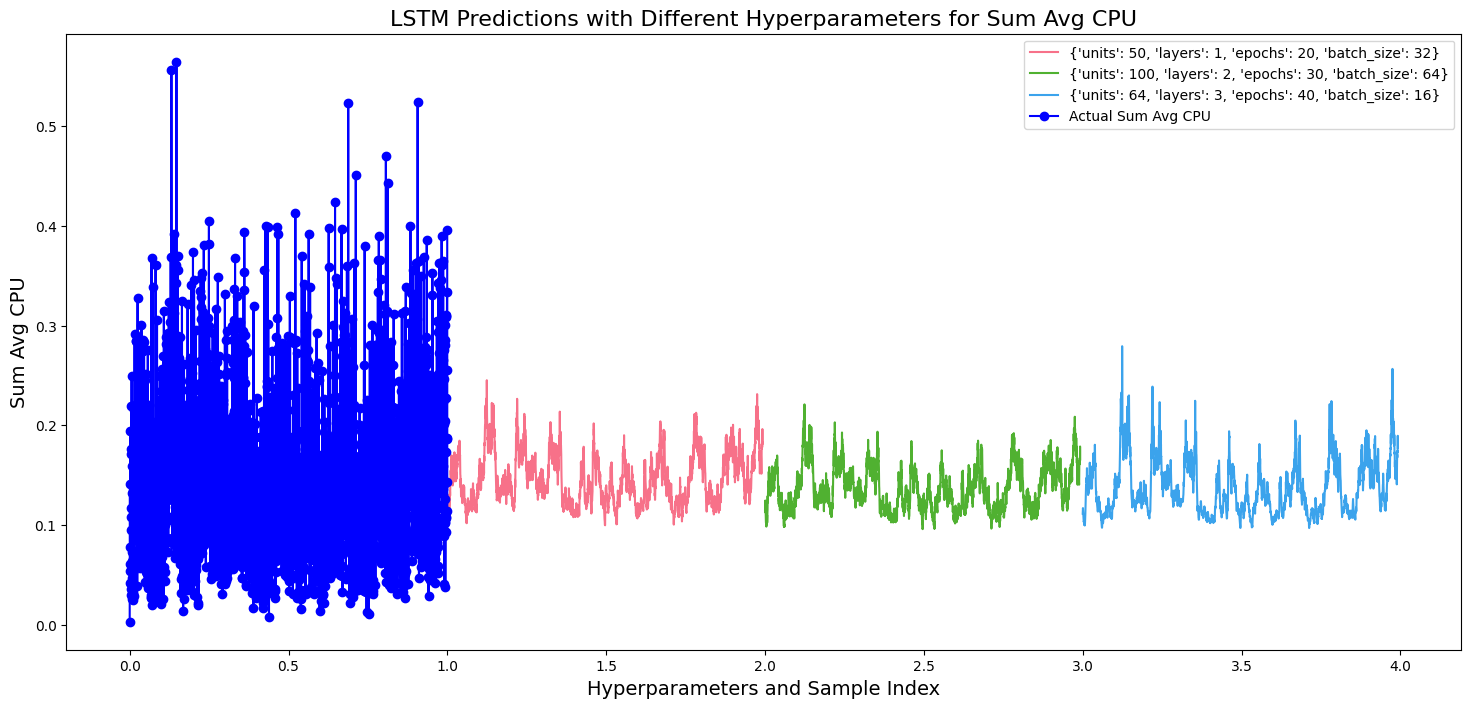

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plot_data = pd.DataFrame({
    'Parameter': np.concatenate([[str(result['params'])] * len(result['predictions']) for result in results]),
    'Predicted Sum Avg CPU': np.concatenate([result['predictions'] for result in results]),
    'Sample Index': np.concatenate([np.arange(len(result['predictions'])) for result in results])
})


plot_data['X'] = plot_data['Parameter'].map({str(hyperparams[i]): i + 1 for i in range(len(hyperparams))}) + plot_data['Sample Index'] / len(test_intervals_df)


plt.figure(figsize=(18, 8))
sns.lineplot(data=plot_data, x='X', y='Predicted Sum Avg CPU', hue='Parameter', palette='husl')


plt.plot(test_intervals_df.index / len(test_intervals_df), test_intervals_df['sum_avg_cpu'], marker='o', color='blue', label='Actual Sum Avg CPU')


plt.title('LSTM Predictions with Different Hyperparameters for Sum Avg CPU', fontsize=16)
plt.xlabel('Hyperparameters and Sample Index', fontsize=14)
plt.ylabel('Sum Avg CPU', fontsize=14)
plt.legend()
plt.show()
